In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


from skimage.io import imread, imshow, show, imshow_collection
from skimage.transform import resize, rescale, rotate

warnings.filterwarnings('ignore')

# Load Data

In [2]:
data_train_1 = pickle.load(open("data/data_train_flatten_batch_1.pkl", "rb"))
data_train_2 = pickle.load(open("data/data_train_flatten_batch_2.pkl", "rb"))
labels_train_1 = pickle.load(open("data/labels_train_batch_1.pkl", "rb"))
labels_train_2 = pickle.load(open("data/labels_train_batch_2.pkl", "rb"))

data_train = np.concatenate((data_train_1, data_train_2))
labels_train = np.concatenate((labels_train_1, labels_train_2))

data_test = pickle.load(open("data/data_test_flatten.pkl", "rb"))
labels_test = pickle.load(open("data/labels_test.pkl", "rb"))

# Shuffle train set
data_train, labels_train = shuffle(data_train, labels_train, random_state=25)

# Scale Data

In [3]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(data_train)
X_test_std = scaler.transform(data_test)

# PCA
We will use a 95% PCA

In [4]:
print("original number of features:", X_train_std.shape[1])
pca = PCA(0.95)
pca.fit(X_train_std)
print("Number of pricipal components:", pca.n_components_)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

original number of features: 3072
Number of pricipal components: 221


# Train Model

In [5]:
m = RandomForestClassifier(random_state=25, n_jobs=4)

parameters = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"]
}]

grid_search = GridSearchCV(m, parameters, verbose=3, scroring="f1_macro")
grid_search.fit(X_train_pca, labels_train)
model = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [6]:
print("Model optimal parameters".upper())
print("criterion:", model.get_params()["criterion"])
print("max_features:", model.get_params()["max_features"])
print("n_jobs:", model.get_params()["n_jobs"])

MODEL OPTIMAL PARAMETERS
criterion: gini
max_features: sqrt


# Test Model

In [7]:
predictions = model.predict(X_test_pca)

accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions, average="macro")
recall = recall_score(labels_test, predictions, average="macro")
f1_macro = f1_score(labels_test, predictions, average="macro")

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%\nF1 macro: {:.4f}%".format(accuracy*100, precision*100, recall*100, f1_macro*100))

Accuracy score: 0.4338


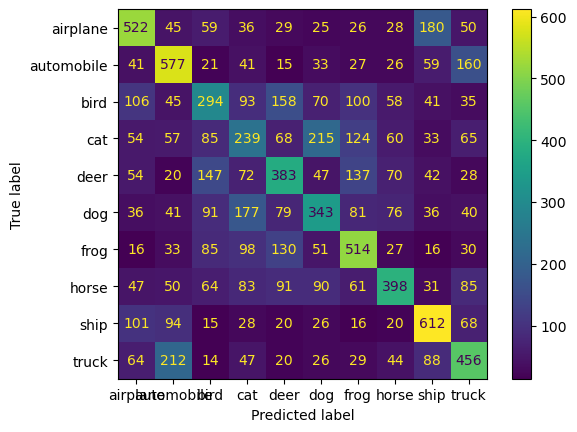

In [8]:
cm = confusion_matrix(labels_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

# Save Model

In [9]:
model_file_name = "random_forest_32x32_PCA.pkl"
pickle.dump(model, open(model_file_name, "wb"))

# Black And White

## Load data

In [10]:
train_batches = []
labels_batches = []

for i in [1, 2, 3, 4, 5]:
    data_filepath = "data/data_train_bw_flatten_batch_" + str(i) + ".pkl"
    labels_filepath = "data/labels_train_bw_batch_" + str(i) + ".pkl"
    train_batches.append(pickle.load(open(data_filepath, "rb")))
    labels_batches.append(pickle.load(open(labels_filepath, "rb")))
    
data_train_bw = np.concatenate(train_batches)
labels_train_bw = np.concatenate(labels_batches)

data_test_bw = pickle.load(open("data/data_test_bw_flatten.pkl", "rb"))
labels_test_bw = pickle.load(open("data/labels_test_bw.pkl", "rb"))

# Shuffle train set
data_train_bw, labels_train_bw = shuffle(data_train_bw, labels_train_bw, random_state=25)

## Scale data

In [11]:
scaler = StandardScaler()

X_train_std_bw = scaler.fit_transform(data_train_bw)
X_test_std_bw = scaler.transform(data_test_bw)

## PCA
We will use a 95% PCA

In [12]:
del pca
print("original number of features:", X_train_std_bw.shape[1])
pca = PCA(0.95)
pca.fit(X_train_std_bw)
print("Number of pricipal components:", pca.n_components_)

X_train_bw_pca = pca.transform(X_train_std_bw)
X_test_bw_pca = pca.transform(X_test_std_bw)

original number of features: 1024
Number of pricipal components: 163


## Train model

In [13]:
m = RandomForestClassifier(random_state=25)

parameters = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"]
}]

grid_search = GridSearchCV(m, parameters, verbose=3, n_jobs=2, scoring="f1_macro")
grid_search.fit(X_train_bw_pca, labels_train_bw)
model_bw = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [14]:
print("Model optimal parameters".upper())
print("criterion:", model_bw.get_params()["criterion"])
print("max_features:", model_bw.get_params()["max_features"])

MODEL OPTIMAL PARAMETERS
criterion: gini
max_features: sqrt


## Test model

In [15]:
predictions_bw = model_bw.predict(X_test_bw_pca)

accuracy_bw = accuracy_score(labels_test_bw, predictions_bw)
precision_bw = precision_score(labels_test_bw, predictions_bw, average="macro")
recall_bw = recall_score(labels_test_bw, predictions_bw, average="macro")
f1_macro_bw = f1_score(labels_test_bw, predictions_bw, average="macro")

print("Accuracy score: {:.4f}%\nPrecision macro: {:.4f}%\nRecall macro: {:.4f}%\nF1 macro: {:.4f}%".format(accuracy_bw*100, precision_bw*100, recall_bw*100, f1_macro_bw*100))

Accuracy score: 0.3725


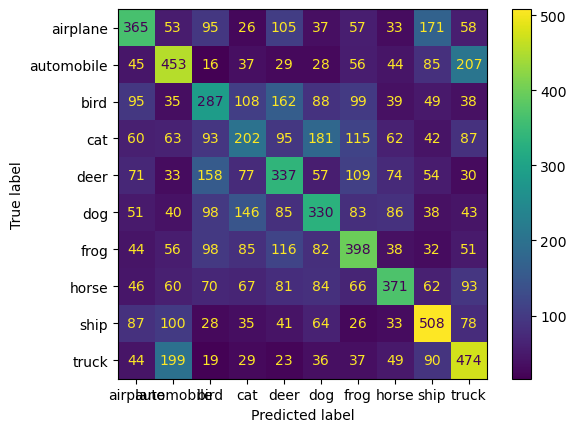

In [16]:
cm = confusion_matrix(labels_test_bw, predictions_bw, labels=model_bw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_bw.classes_)
disp.plot()
plt.show()

## Save model

In [17]:
model_file_name_bw = "random_forest_32x32_bw_PCA.pkl"
pickle.dump(model_bw, open(model_file_name_bw, "wb"))